In [99]:
pip install yfinance

Note: you may need to restart the kernel to use updated packages.


In [33]:
# Stock Price Prediction with LSTM
# ==================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import math
import datetime as dt
import talib
import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)
tf.random.set_seed(42)

In [37]:
def fetch_stock_data(ticker, start_date, end_date):
    stock_data = yf.download(ticker, start=start_date, end=end_date)
    print(f"Downloaded {len(stock_data)} records of {ticker} data")
    return stock_data



In [39]:
def add_technical_indicators(df):
    close = df['Close'].to_numpy().flatten()  # Ensures 1D array

    df['RSI'] = talib.RSI(close, timeperiod=14)
    df['SMA_20'] = talib.SMA(close, timeperiod=20)
    df['SMA_50'] = talib.SMA(close, timeperiod=50)
    df['EMA_20'] = talib.EMA(close, timeperiod=20)

    macd, macd_signal, macd_hist = talib.MACD(close)
    df['MACD'] = macd
    df['MACD_signal'] = macd_signal

    upper, middle, lower = talib.BBANDS(close, timeperiod=20)
    df['BB_upper'] = upper
    df['BB_middle'] = middle
    df['BB_lower'] = lower

    df.dropna(inplace=True)
    return df


In [41]:
def prepare_data_for_lstm(df, feature_columns, target_column, sequence_length=60, split_ratio=0.8):
    data_features = df[feature_columns].values
    data_target = df[target_column].values.reshape(-1, 1)
    scaler_x = MinMaxScaler()
    scaler_y = MinMaxScaler()
    data_features_scaled = scaler_x.fit_transform(data_features)
    data_target_scaled = scaler_y.fit_transform(data_target)
    X, y = [], []
    for i in range(sequence_length, len(data_features_scaled)):
        X.append(data_features_scaled[i-sequence_length:i])
        y.append(data_target_scaled[i])
    X, y = np.array(X), np.array(y)
    train_size = int(len(X) * split_ratio)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]
    print(f"Training data shape: {X_train.shape}")
    print(f"Testing data shape: {X_test.shape}")
    return X_train, y_train, X_test, y_test, scaler_x, scaler_y


In [43]:
def build_lstm_model(input_shape, lstm_units=50, dropout_rate=0.2):
    model = Sequential()
    model.add(LSTM(lstm_units, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(lstm_units))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model


In [45]:
def train_lstm_model(model, X_train, y_train, epochs=50, batch_size=32, validation_split=0.1):
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,
                        validation_split=validation_split, callbacks=[early_stopping], verbose=1)
    return history


In [97]:
def evaluate_model(model, X_test, y_test, scaler_y):
    predictions = model.predict(X_test)
    predictions_original = scaler_y.inverse_transform(predictions)
    y_test_original = scaler_y.inverse_transform(y_test)
    mse = mean_squared_error(y_test_original, predictions_original)
    rmse = math.sqrt(mse)
    mae = mean_absolute_error(y_test_original, predictions_original)
    r2 = r2_score(y_test_original, predictions_original)
    print('Model Evaluation Metrics:')
    print(f'MSE: {mse:.4f}, RMSE: {rmse:.4f}, MAE: {mae:.4f}, R2: {r2:.4f}')
    return predictions_original, y_test_original, {'MSE': mse, 'RMSE': rmse, 'MAE': mae, 'R2': r2}


In [49]:
def plot_predictions(y_true, y_pred, title='Stock Price Prediction'):
    plt.figure(figsize=(12, 6))
    plt.plot(y_true, label='Actual')
    plt.plot(y_pred, label='Predicted')
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.show()


In [51]:
def plot_training_history(history):
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training History')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

In [53]:
def forecast_future_prices(model, last_sequence, scaler_x, scaler_y, n_steps=30):
    future_predictions = []
    current_sequence = last_sequence.copy()
    n_features = current_sequence.shape[2]
    for _ in range(n_steps):
        pred = model.predict(current_sequence)[0, 0]
        future_predictions.append(pred)
        next_input = np.zeros((1, 1, n_features))
        next_input[0, 0, 0] = pred
        for j in range(1, n_features):
            next_input[0, 0, j] = current_sequence[0, -1, j]
        current_sequence = np.append(current_sequence[:, 1:, :], next_input, axis=1)
    future_predictions = np.array(future_predictions).reshape(-1, 1)
    return scaler_y.inverse_transform(future_predictions)


In [79]:
def plot_forecast(historical, forecasted, title='Forecast'):
    plt.figure(figsize=(12, 6))
    plt.plot(range(len(historical)), historical, label='Historical')
    plt.plot(range(len(historical), len(historical) + len(forecasted)), forecasted, label='Forecast')
    plt.axvline(x=len(historical) - 1, color='green', linestyle='--', label='Forecast Start')
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.show()



[*********************100%***********************]  1 of 1 completed

Downloaded 1854 records of AAPL data
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1854 entries, 2018-01-02 to 2025-05-16
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   (Close, AAPL)   1854 non-null   float64
 1   (High, AAPL)    1854 non-null   float64
 2   (Low, AAPL)     1854 non-null   float64
 3   (Open, AAPL)    1854 non-null   float64
 4   (Volume, AAPL)  1854 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 86.9 KB
None
Price           Close       High        Low       Open     Volume
Ticker           AAPL       AAPL       AAPL       AAPL       AAPL
Date                                                             
2018-01-02  40.426819  40.436208  39.722764  39.933983  102223600
2018-01-03  40.419796  40.964267  40.356434  40.490202  118071600
2018-01-04  40.607536  40.710798  40.384586  40.492539   89738400
2018-01-05  41.069859  41.156691  40.612224  40.703751   94640000
2018-0

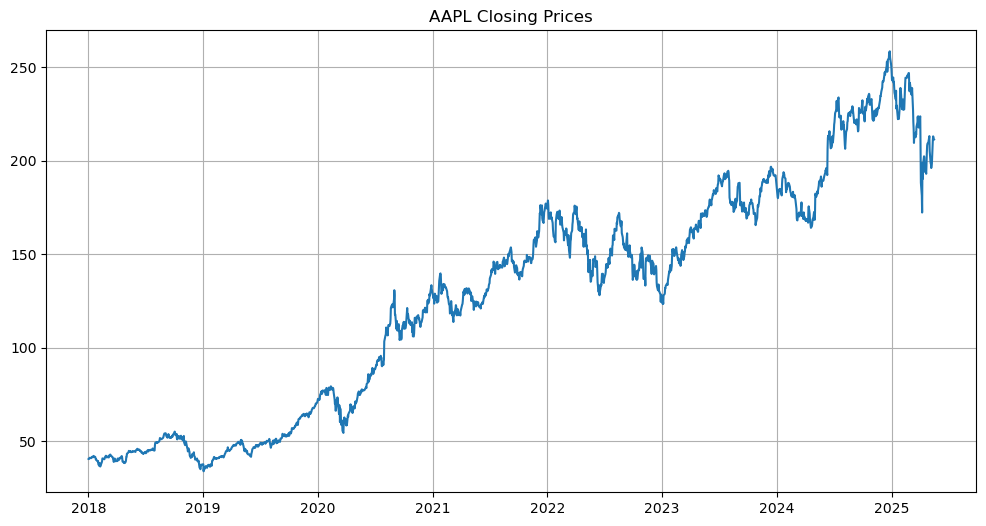

Training data shape: (1396, 60, 7)
Testing data shape: (349, 60, 7)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                   │ (None, 60, 100)        │        43,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 60, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 100)            │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 123,701 (483.21 KB)

 Trainable params: 123,701 (483.21 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 0.0149 - val_loss: 9.5356e-04
Epoch 2/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - loss: 0.0023 - val_loss: 0.0015
Epoch 3/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - loss: 0.0017 - val_loss: 5.6118e-04
Epoch 4/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - loss: 0.0018 - val_loss: 5.5619e-04
Epoch 5/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - loss: 0.0015 - val_loss: 5.2051e-04
Epoch 6/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - loss: 0.0013 - val_loss: 6.5310e-04
Epoch 7/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - loss: 0.0014 - val_loss: 3.8160e-04
Epoch 8/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - loss: 0.0013 - val_loss: 0.0037
Epoch 9/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - loss: 0.0013 - val_loss: 0.0016
Epoch 10/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - loss: 0.0013 - val_loss: 8.5227e-04
Epoch 11/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - loss: 0.0012 - val_loss: 0.0030
Epoch 12/100
40/40 ━━━━━

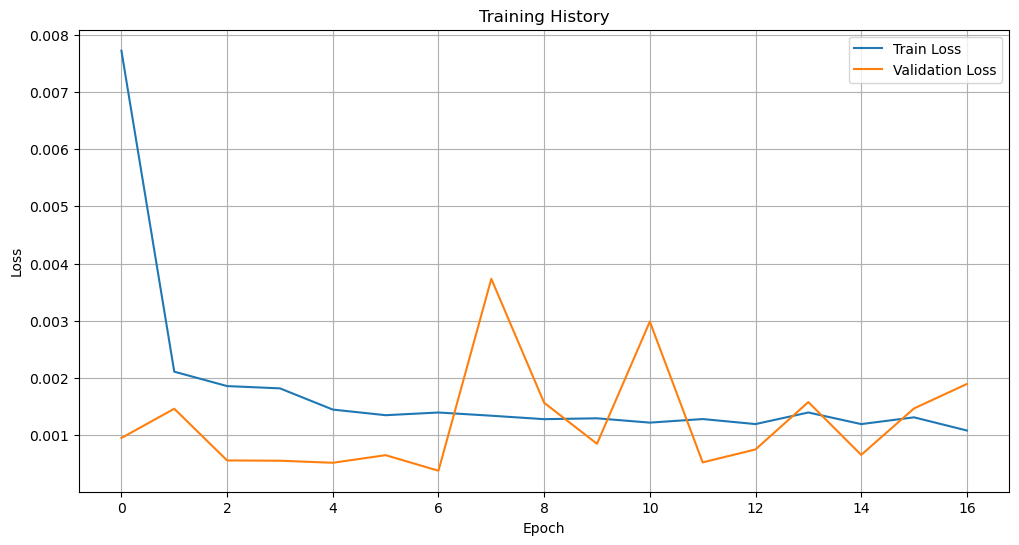

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Model Evaluation Metrics:
MSE: 113.4875, RMSE: 10.6531, MAE: 8.7248, R2: 0.8106


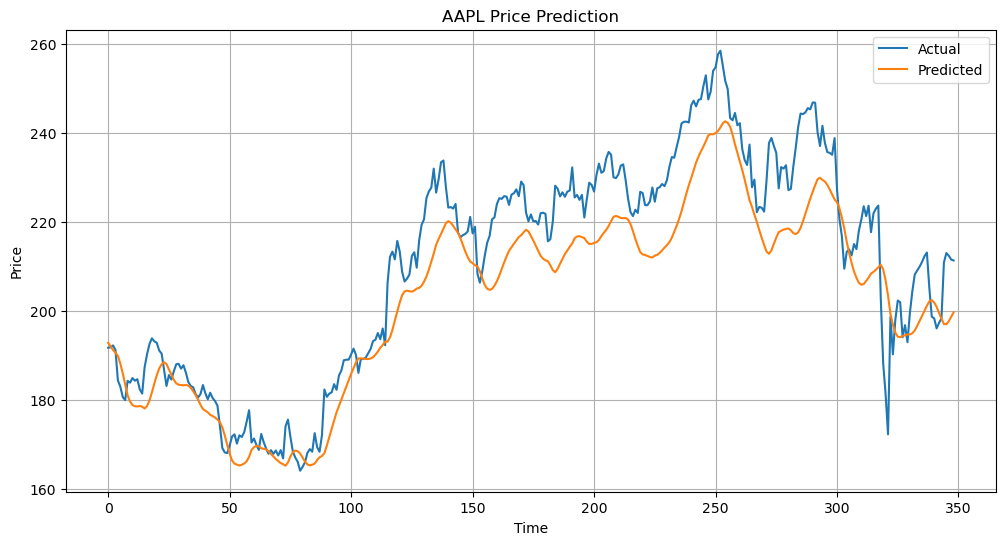

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━

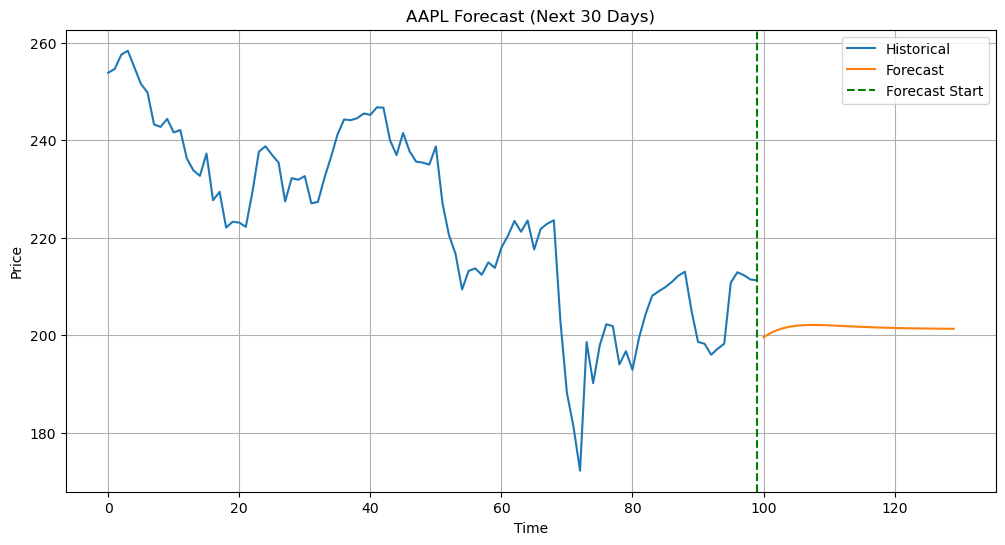

Model saved as 'my_model.keras'


In [81]:
if __name__ == "__main__":
    ticker = 'AAPL'
    start_date = '2018-01-01'
    end_date = dt.datetime.now().strftime('%Y-%m-%d')
    sequence_length = 60

    df = fetch_stock_data(ticker, start_date, end_date)
    print(df.info())
    print(df.head())

    plt.figure(figsize=(12, 6))
    plt.plot(df['Close'])
    plt.title(f'{ticker} Closing Prices')
    plt.grid(True)
    plt.show()

    df = add_technical_indicators(df)
    feature_columns = ['Close', 'RSI', 'SMA_20', 'EMA_20', 'MACD', 'BB_upper', 'BB_lower']
    target_column = 'Close'

    X_train, y_train, X_test, y_test, scaler_x, scaler_y = prepare_data_for_lstm(
        df, feature_columns, target_column, sequence_length)

    input_shape = (X_train.shape[1], X_train.shape[2])
    model = build_lstm_model(input_shape, lstm_units=100, dropout_rate=0.3)
    model.summary()

    history = train_lstm_model(model, X_train, y_train, epochs=100, batch_size=32, validation_split=0.1)

    plot_training_history(history)

    predictions, actual, metrics = evaluate_model(model, X_test, y_test, scaler_y)

    plot_predictions(actual, predictions, title=f'{ticker} Price Prediction')

    last_sequence = X_test[-1].reshape(1, X_test.shape[1], X_test.shape[2])
    future_prices = forecast_future_prices(model, last_sequence, scaler_x, scaler_y, n_steps=30)

    historical_prices = df[target_column][-100:].values
    plot_forecast(historical_prices, future_prices.flatten(), title=f'{ticker} Forecast (Next 30 Days)')

    model.save('my_model.keras')
    print("Model saved as 'my_model.keras'")


In [93]:
def create_trading_strategy(actual_prices, predicted_prices, initial_capital=34000):
    """
    Create a simple trading strategy based on predictions
    
    Parameters:
    actual_prices (array): Actual stock prices
    predicted_prices (array): Predicted stock prices
    initial_capital (float): Initial investment capital
    
    Returns:
    DataFrame: Trading decisions and portfolio value over time
    """
    # Ensure inputs are 1D
    actual_prices = np.array(actual_prices).flatten()
    predicted_prices = np.array(predicted_prices).flatten()

    trading_df = pd.DataFrame({
        'Actual': actual_prices,
        'Predicted': predicted_prices
    })

    # Calculate direction of price movement
    trading_df['Actual_Direction'] = np.where(
        trading_df['Actual'].shift(-1) > trading_df['Actual'], 1, -1
    )
    trading_df['Predicted_Direction'] = np.where(
        trading_df['Predicted'].shift(-1) > trading_df['Predicted'], 1, -1
    )

    # Generate trading signals (1 for buy, -1 for sell)
    trading_df['Position'] = trading_df['Predicted_Direction'].shift(1)
    trading_df['Position'].fillna(0, inplace=True)
    trading_df['Position'] = trading_df['Position'].astype(int)

    # Calculate returns
    trading_df['Market_Return'] = trading_df['Actual'].pct_change() * 100
    trading_df['Strategy_Return'] = trading_df['Position'] * trading_df['Market_Return']

    # Cumulative returns
    trading_df['Cumulative_Market_Return'] = (1 + trading_df['Market_Return'] / 100).cumprod()
    trading_df['Cumulative_Strategy_Return'] = (1 + trading_df['Strategy_Return'] / 100).cumprod()

    # Portfolio value over time
    trading_df['Market_Portfolio'] = initial_capital * trading_df['Cumulative_Market_Return']
    trading_df['Strategy_Portfolio'] = initial_capital * trading_df['Cumulative_Strategy_Return']

    return trading_df


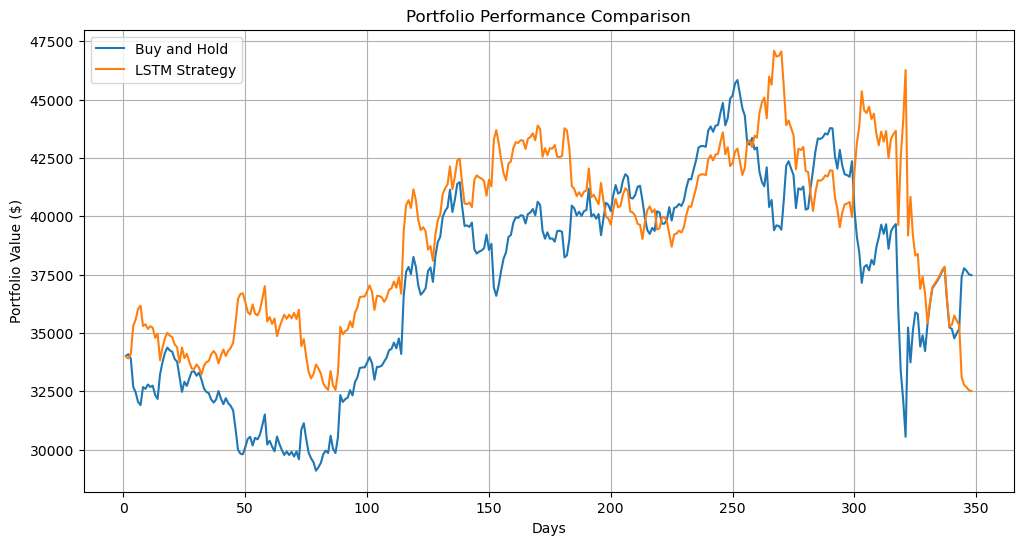


Trading Strategy Performance:
Initial Capital: $34000.00
Final Value (Buy and Hold): $37479.62 (Return: 10.23%)
Final Value (LSTM Strategy): $32514.51 (Return: -4.37%)


In [101]:
# Execute trading strategy 
trading_results = create_trading_strategy(actual, predictions)

# Plot portfolio performance
plt.figure(figsize=(12, 6))
plt.plot(trading_results['Market_Portfolio'], label='Buy and Hold')
plt.plot(trading_results['Strategy_Portfolio'], label='LSTM Strategy')
plt.title('Portfolio Performance Comparison')
plt.xlabel('Days')
plt.ylabel('Portfolio Value ($)')
plt.legend()
plt.grid(True)
plt.show()

# Print strategy performance metrics
initial_capital = 34000
final_market_value = trading_results['Market_Portfolio'].iloc[-1]
final_strategy_value = trading_results['Strategy_Portfolio'].iloc[-1]

print(f"\nTrading Strategy Performance:")
print(f"Initial Capital: ${initial_capital:.2f}")
print(f"Final Value (Buy and Hold): ${final_market_value:.2f} (Return: {(final_market_value/initial_capital - 1)*100:.2f}%)")
print(f"Final Value (LSTM Strategy): ${final_strategy_value:.2f} (Return: {(final_strategy_value/initial_capital - 1)*100:.2f}%)")


In [29]:
import joblib
joblib.dump(trading_results, 'model_path.pkl')


['model_path.pkl']

In [31]:
import joblib

def load_model(path):
    return joblib.load(path)
